# <center/>混合精度训练体验

## 概述

神经网络训练的时候，数据和权重等各种参数一般使用单精度浮点数（float32）进行计算和存储。在采用复杂神经网络进行训练时，由于计算量的增加，机器的内存开销变得非常大。经常玩模型训练的人知道，内存资源的不足会导致训练的效率变低，简单说就是训练变慢，有没有什么比较好的方法，在不提升硬件资源的基础上加快训练呢？这次我们介绍其中一种方法--混合精度训练，说白了就是将参数取其一半长度进行计算，即使用半精度浮点数（float16）计算，这样就能节省一半内存开销。当然，为了保证模型的精度，不能把所有的计算参数都换成半精度。为了兼顾模型精度和训练效率，MindSpore在框架中设置了一个自动混合精度训练的功能，本次体验我们将使用ResNet-50网络进行训练，体验MindSpore混合精度训练和单精度训练的不同之处。

整体过程如下：

1. MindSpore混合精度训练的原理介绍。
2. 数据集准备。
3. 定义动态学习率。
4. 定义损失函数。
5. 定义ResNet-50网络。
6. 定义`One_Step_Time`回调函数。
7. 定义训练网络（此处设置自动混合精度训练参数`amp_level`）。
8. 验证模型精度。
9. 混合精度训练和单精度训练的对比。

> 你可以在这里找到完整可运行的样例代码：<https://gitee.com/mindspore/mindspore/tree/master/model_zoo/official/cv/resnet>。

## MindSpore混合精度训练原理介绍

![image](https://www.mindspore.cn/tutorial/zh-CN/master/_images/mix_precision.jpg)

1. 参数以FP32存储；
2. 正向计算过程中，遇到FP16算子，需要把算子输入和参数从FP32 `cast`成FP16进行计算；
3. 将Loss层设置为FP32进行计算；
4. 反向计算过程中，首先乘以Loss Scale值，避免反向梯度过小而产生下溢；
5. FP16参数参与梯度计算，其结果将被cast回FP32；
6. 除以`Loss scale`值，还原被放大的梯度；
7. 判断梯度是否存在溢出，如果溢出则跳过更新，否则优化器以FP32对原始参数进行更新。

从上可以理解(float16为半精度浮点数，float32为单精度浮点数)，MindSpore是将网络中的前向计算部分`cast`成半精度浮点数进行计算，以节省内存空间，提升性能，同时将`loss`值保持单精度浮点数进行计算和存储，`weight`使用半精度浮点数进行计算，单精度浮点数进行保存，通过这样操作即提升了训练效率，又保证了一定的模型精度，达到提升训练性能的目的。

## 数据集准备

数据集下载地址：<https://www.cd.toronto.edu/~kriz/cifar-10-python.tar.gz>。

数据集下载后，解压至jupyter的工作路径+/datasets/cifar10，由于测试数据集和训练数据集在一个文件夹中，需要你分开两个文件夹存放，存放形式如下。

如果放置正确，可以在开启的jupyter的首页网址+`/tree/datasets/cifar10`，找到`test`和`train`文件夹。

### 数据增强

先将CIFAR-10的原始数据集可视化：

the cifar dataset size is : 50000
the tensor of image is: (32, 32, 3)


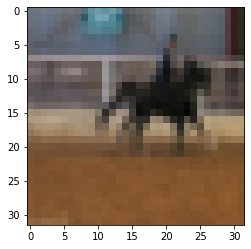

In [1]:
import mindspore.dataset.engine as de
import matplotlib.pyplot as plt
import numpy as np

train_path = "./datasets/cifar10/train"
ds = de.Cifar10Dataset(train_path, num_parallel_workers=8, shuffle=True)
print("the cifar dataset size is :", ds.get_dataset_size())
dict1 = ds.create_dict_iterator()
datas = dict1.get_next()
image = datas["image"]
print("the tensor of image is:", image.shape)
plt.imshow(np.array(image))
plt.show()

可以看到CIFAR-10总共包含了50000张32×32的彩色图片。

### 定义数据增强函数

In [2]:
import os
import mindspore.common.dtype as mstype
import mindspore.dataset.engine as de
import mindspore.dataset.transforms.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2

def create_dataset(dataset_path, do_train, repeat_num=1, batch_size=32, target="GPU"):
    
    ds = de.Cifar10Dataset(dataset_path, num_parallel_workers=8, shuffle=True)
    
    # define map operations
    trans = []
    if do_train:
        trans += [
            C.RandomCrop((32, 32), (4, 4, 4, 4)),
            C.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        C.Resize((224, 224)),
        C.Rescale(1.0 / 255.0, 0.0),
        C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        C.HWC2CHW()
    ]

    type_cast_op = C2.TypeCast(mstype.int32)

    ds = ds.map(input_columns="label", num_parallel_workers=8, operations=type_cast_op)
    ds = ds.map(input_columns="image", num_parallel_workers=8, operations=trans)

    # apply batch operations
    ds = ds.batch(batch_size, drop_remainder=True)
    # apply dataset repeat operation
    ds = ds.repeat(repeat_num)

    return ds

定义完成数据集增强函数后，我们来看一下，数据集增强后的效果是如何的：

the cifar dataset size is: 1562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the tensor of image is: (32, 3, 224, 224)


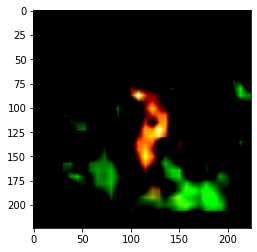

In [3]:
ds = create_dataset(train_path, do_train=True, repeat_num=1, batch_size=32, target="GPU")
print("the cifar dataset size is:", ds.get_dataset_size())
dict1 = ds.create_dict_iterator()
datas = dict1.get_next()
image = datas["image"]
single_pic = np.transpose(image[0], (1,2,0))
print("the tensor of image is:", image.shape)
plt.imshow(np.array(single_pic))
plt.show()

cifar10通过数据增强后的，变成了一共有1562个batch，张量为(32,3,224,224)的数据集。

## 定义动态学习率函数

定义动态学习率用于ResNet-50网络训练。

In [4]:
import math
import numpy as np

def get_lr(lr_init, lr_end, lr_max, warmup_epochs, total_epochs, steps_per_epoch, lr_decay_mode):
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    if lr_decay_mode == 'steps':
        decay_epoch_index = [0.3 * total_steps, 0.6 * total_steps, 0.8 * total_steps]
        for i in range(total_steps):
            if i < decay_epoch_index[0]:
                lr = lr_max
            elif i < decay_epoch_index[1]:
                lr = lr_max * 0.1
            elif i < decay_epoch_index[2]:
                lr = lr_max * 0.01
            else:
                lr = lr_max * 0.001
            lr_each_step.append(lr)
            
    elif lr_decay_mode == 'poly':
        if warmup_steps != 0:
            inc_each_step = (float(lr_max) - float(lr_init)) / float(warmup_steps)
        else:
            inc_each_step = 0
        for i in range(total_steps):
            if i < warmup_steps:
                lr = float(lr_init) + inc_each_step * float(i)
            else:
                base = (1.0 - (float(i) - float(warmup_steps)) / (float(total_steps) - float(warmup_steps)))
                lr = float(lr_max) * base * base
                if lr < 0.0:
                    lr = 0.0
            lr_each_step.append(lr)
    else:
        for i in range(total_steps):
            if i < warmup_steps:
                lr = lr_init + (lr_max - lr_init) * i / warmup_steps
            else:
                lr = lr_max - (lr_max - lr_end) * (i - warmup_steps) / (total_steps - warmup_steps)
            lr_each_step.append(lr)

    lr_each_step = np.array(lr_each_step).astype(np.float32)

    return lr_each_step

def linear_warmup_lr(current_step, warmup_steps, base_lr, init_lr):
    lr_inc = (float(base_lr) - float(init_lr)) / float(warmup_steps)
    lr = float(init_lr) + lr_inc * current_step
    return lr

def warmup_cosine_annealing_lr(lr, steps_per_epoch, warmup_epochs, max_epoch=120, global_step=0):
    base_lr = lr
    warmup_init_lr = 0
    total_steps = int(max_epoch * steps_per_epoch)
    warmup_steps = int(warmup_epochs * steps_per_epoch)
    decay_steps = total_steps - warmup_steps

    lr_each_step = []
    for i in range(total_steps):
        if i < warmup_steps:
            lr = linear_warmup_lr(i + 1, warmup_steps, base_lr, warmup_init_lr)
        else:
            linear_decay = (total_steps - i) / decay_steps
            cosine_decay = 0.5 * (1 + math.cos(math.pi * 2 * 0.47 * i / decay_steps))
            decayed = linear_decay * cosine_decay + 0.00001
            lr = base_lr * decayed
        lr_each_step.append(lr)

    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[global_step:]
    return learning_rate


## 定义损失函数

In [5]:
from mindspore.nn.loss.loss import _Loss
from mindspore.ops import operations as P
from mindspore.ops import functional as F
from mindspore import Tensor
import mindspore.nn as nn

class CrossEntropy(_Loss):
    def __init__(self, smooth_factor=0., num_classes=1001):
        super(CrossEntropy, self).__init__()
        self.onehot = P.OneHot()
        self.on_value = Tensor(1.0 - smooth_factor, mstype.float32)
        self.off_value = Tensor(1.0 * smooth_factor / (num_classes - 1), mstype.float32)
        self.ce = nn.SoftmaxCrossEntropyWithLogits()
        self.mean = P.ReduceMean(False)

    def construct(self, logit, label):
        one_hot_label = self.onehot(label, F.shape(logit)[1], self.on_value, self.off_value)
        loss = self.ce(logit, one_hot_label)
        loss = self.mean(loss, 0)
        return loss

## 定义深度神经网络

本篇使用的MindSpore中的ResNet-50网络模型的源代码。

In [6]:
from mindspore.common.tensor import Tensor
import mindspore.common.initializer as weight_init

def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)


def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)


class ResidualBlock(nn.Cell):
    expansion = 4

    def __init__(self,
                 in_channel,
                 out_channel,
                 stride=1):
        super(ResidualBlock, self).__init__()

        channel = out_channel // self.expansion
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)

        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)

        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)

        self.relu = nn.ReLU()

        self.down_sample = False

        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None

        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride),
                                                        _bn(out_channel)])
        self.add = P.TensorAdd()

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.down_sample:
            identity = self.down_sample_layer(identity)

        out = self.add(out, identity)
        out = self.relu(out)

        return out

class ResNet(nn.Cell):

    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 strides,
                 num_classes):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = P.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])

        self.mean = P.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
  
        layers = []

        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)

        return out

def resnet50(class_num=10):

    return ResNet(ResidualBlock,
                  [3, 4, 6, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)

def resnet101(class_num=1001):
    return ResNet(ResidualBlock,
                  [3, 4, 23, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)

### 定义回调函数Time_per_Step来计算单步训练耗时

`Time_per_Step`用于计算每步训练的时间消耗情况，方便对比混合精度训练和单精度训练的性能区别。

In [7]:
from mindspore.train.callback import Callback
import time

class Time_per_Step(Callback):
    def step_begin(self, run_context):
        cb_params = run_context.original_args()
        cb_params.init_time = time.time()
        
    def step_end(selfself, run_context):
        cb_params = run_context.original_args()
        one_step_time = (time.time() - cb_params.init_time) * 1000
        print(one_step_time, "ms")

## 定义训练网络

### 设置混合精度训练并执行训练

由于MindSpore已经添加了自动混合精度训练功能，我们这里操作起来非常方便，只需要在Model中添加参数`amp_level=O2`就完成了设置GPU模式下的混合精度训练设置。运行时，将会自动混合精度训练模型。

`amp_level`的参数详情：

`O0`：表示不做任何变化，即单精度训练，系统默认`O0`。

`O2`：表示将网络中的参数计算变为float16。适用于GPU环境。

`O3`：表示将网络中的参数计算变为float16，同时需要在Model中添加参数`keep_batchnorm_fp32=False`。适用于Ascend环境。

在`Model`中设置`amp_level=O2`后即可执行混合精度训练：

In [8]:
"""train ResNet-50"""
import os
import random
import argparse
from mindspore import context
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.model import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net



parser = argparse.ArgumentParser(description='Image classification')
parser.add_argument('--net', type=str, default="resnet50", help='Resnet Model, either resnet50 or resnet101')
parser.add_argument('--dataset', type=str, default="cifar10", help='Dataset, either cifar10 or imagenet2012')
parser.add_argument('--run_distribute', type=bool, default=False, help='Run distribute')
parser.add_argument('--device_target', type=str, default='GPU', help='Device target')
parser.add_argument('--pre_trained', type=str, default=None, help='Pretrained checkpoint path')
args_opt = parser.parse_known_args()[0]

random.seed(1)
np.random.seed(1)
de.config.set_seed(1)

if __name__ == '__main__':

    context.set_context(mode=context.GRAPH_MODE,enable_auto_mixed_precision=False, device_target="GPU")
    ckpt_save_dir= "./resnet_ckpt"
    batch_size = 32
    epoch_size = 10
    dataset_path = "./datasets/cifar10/train"
    test_path = "./datasets/cifar10/test"
    
    # create dataset
    dataset = create_dataset(dataset_path=dataset_path, do_train=True, repeat_num=1,
                                 batch_size=batch_size, target="GPU")
    step_size = dataset.get_dataset_size()
    # define net
    net = resnet50(class_num=10)
    
    # init weight
    if args_opt.pre_trained:
        param_dict = load_checkpoint(args_opt.pre_trained)
        load_param_into_net(net, param_dict)
    else:
        for _, cell in net.cells_and_names():
            if isinstance(cell, nn.Conv2d):
                cell.weight.default_input = weight_init.initializer(weight_init.XavierUniform(),
                                                                    cell.weight.default_input.shape,
                                                                    cell.weight.default_input.dtype).to_tensor()
            if isinstance(cell, nn.Dense):
                cell.weight.default_input = weight_init.initializer(weight_init.TruncatedNormal(),
                                                                    cell.weight.default_input.shape,
                                                                    cell.weight.default_input.dtype).to_tensor()
    # init lr
    warmup_epochs = 5
    lr_init = 0.01
    lr_end = 0.00001
    lr_max = 0.1
    lr = get_lr(lr_init=lr_init, lr_end=lr_end, lr_max=lr_max,
                        warmup_epochs=warmup_epochs, total_epochs=epoch_size, steps_per_epoch=step_size,
                        lr_decay_mode='poly')
    lr = Tensor(lr)

    # define opt
    loss_scale = 1024
    momentum = 0.9
    weight_decay = 1e-4
    
    # define loss, model
    loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), lr, momentum)
    model = Model(net, loss_fn=loss, optimizer=opt, metrics={'acc'},amp_level="O2")
    
    # define callbacks
    steptime_cb = Time_per_Step()
    time_cb = TimeMonitor(data_size=step_size)
    loss_cb = LossMonitor()

    cb = [time_cb, loss_cb,steptime_cb]
    save_checkpoint = 5
    if save_checkpoint:
        save_checkpoint_epochs = 5
        keep_checkpoint_max = 10
        config_ck = CheckpointConfig(save_checkpoint_steps=save_checkpoint_epochs * step_size,
                                     keep_checkpoint_max=keep_checkpoint_max)
        ckpt_cb = ModelCheckpoint(prefix="resnet", directory=ckpt_save_dir, config=config_ck)
        cb += [ckpt_cb]

    # train model
    model.train(epoch_size, dataset, callbacks=cb, dataset_sink_mode=True)

epoch: 1 step: 1, loss is 2.3015203
37518.837213516235 ms
epoch: 1 step: 2, loss is 2.3068979
197.05581665039062 ms
epoch: 1 step: 3, loss is 2.3115108
189.01705741882324 ms
epoch: 1 step: 4, loss is 2.3279507
188.4777545928955 ms
epoch: 1 step: 5, loss is 2.2853572
188.50111961364746 ms
epoch: 1 step: 6, loss is 2.2706618
188.63296508789062 ms
epoch: 1 step: 7, loss is 2.325651
213.5298252105713 ms
epoch: 1 step: 8, loss is 2.3179858
188.95459175109863 ms
epoch: 1 step: 9, loss is 2.3060834
193.02725791931152 ms
epoch: 1 step: 10, loss is 2.39061
192.83699989318848 ms


......


epoch: 8 step: 323, loss is 0.54335135
190.31238555908203 ms
epoch: 8 step: 324, loss is 0.2202819
190.30189514160156 ms


......


epoch: 10 step: 1545, loss is 0.21533835
192.63434410095215 ms
epoch: 10 step: 1546, loss is 0.14042784
192.5680637359619 ms
epoch: 10 step: 1547, loss is 0.14810953
192.64483451843262 ms
epoch: 10 step: 1548, loss is 0.3791172
192.7051544189453 ms
epoch: 10 step: 1549, loss is 0.

### 验证模型精度

使用模型进行精度验证可以得出以下代码。

In [9]:
# Eval model
eval_dataset_path = "./datasets/cifar10/test"
eval_data = create_dataset(eval_dataset_path,do_train=False)
acc = model.eval(eval_data,dataset_sink_mode=True)
print("Accuracy:",acc)

Accuracy: {'acc': 0.8796073717948718}


## 对比不同网络下的混合精度训练和单精度训练的差别

由于篇幅原因，我们这里只展示了ResNet-50网络的混合精度训练情况。可以在主程序入口的Model中设置参数`amp_level = O0`进行单精度训练，训练完毕后，将结果进行对比，看看两者的情况，下面将我测试的情况做成表格如下。（训练时，笔者使用的GPU为Nvidia Tesla P40，不同的硬件对训练的效率影响较大，下述表格中的数据仅供参考）

|  网络 | 是否混合训练 | 单步训练时间 | epoch | Accuracy
|:------  |:-----| :------- |:--- |:------  
|ResNet-50 |  否  | 232ms   |  10 |  0.881809 
|ResNet-50 |  是  | 192ms   |  10 |  0.879607 

经过多次测试，使用ResNet-50网络,CIFAR-10数据集，进行混合精度训练对整体的训练效率提升了16%，而且对最终模型的精度影响不大，对整体性能调优来说是一个不容忽视的性能提升。

当然，如果你想参考单步训练或者手动设置混合精度训练，可以参考官网教程<https://www.mindspore.cn/tutorial/zh-CN/master/advanced_use/mixed_precision.html>。

## 总结

本次体验我们尝试了在ResNet-50网络中使用混合精度来进行模型训练，并对比了单精度下的训练过程，了解到了混合精度训练的原理和对模型训练的提升效果。